## Хомутов Евгений Васильевич, МСКМ-191
# Вычислительная геномика

In [1]:
import pprint
import numpy as np
import matplotlib.pyplot as plt

Импортируем класс Croupier, который отвечает за генерацию данных и создадим экземпляр класса с заданными значениями вероятности для нечестного кубика, а так же вероятности перехода с честного кубика на нечестный и на себя самого, и вероятности перехода с нечестного кубика на себя и на честный. Проверим что получаем выпавшие знаечение кубика, а так же метку кубика.

В качестве начального распределения возьмем предельное распределение. Решая систему уравнений и нормировочное уравнение:
$$
0.95p_1+ 0.05p_2 = p_1
$$
$$
0.01p_1+ 0.9p_2 = p_2
$$
$$
p_1 + p_2 = 1 
$$
получаем, что искомые вероятности равны (2/3;1/3)

In [2]:
class Croupier():
    def __init__(self):
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': [0.95,0.05], # to F, to U
            'U': [0.1,0.9] # to F, to U
        }
        
        self.startProbability = [2/3,1/3]

        self.currentState = np.random.choice(self.states, p =self.startProbability)
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }


    def changeDice(self):
        self.currentState = np.random.choice(self.states,p=self.transitionsProbability[self.currentState])

    def roll(self):
        return np.random.choice(self.diceValues, p=self.diceValueProbability[self.currentState]), self.currentState

    def __call__(self):
        self.changeDice()
        return self.roll()

In [3]:
casino = Croupier()
for i in range(10):
    print(casino())

(6, 'F')
(6, 'F')
(3, 'F')
(3, 'F')
(5, 'U')
(6, 'U')
(3, 'U')
(1, 'U')
(6, 'U')
(6, 'U')


Сгенерируем датасеты размером 300, 1 000 и 10 000

In [53]:
dataset300 = []
dataset300Labels = []

casino = Croupier()

for i in range(300):
    data, label = casino()
    dataset300.append(data)
    dataset300Labels.append(label)

In [5]:
dataset1000 = []
dataset1000Labels = []

casino = Croupier()

for i in range(1000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

In [6]:
dataset10000 = []
dataset10000Labels = []

casino = Croupier()

for i in range(10000):
    data, label = casino()
    dataset10000.append(data)
    dataset10000Labels.append(label)

Ноль соответсвует честной кости, единица - нечестной.

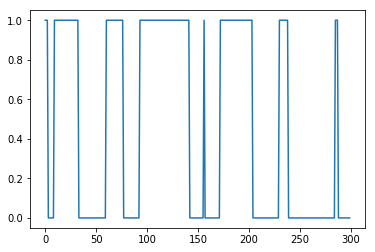

In [7]:
lab300 = [0 if l =='F' else 1 for l in dataset300Labels ]
plt.plot(lab300)

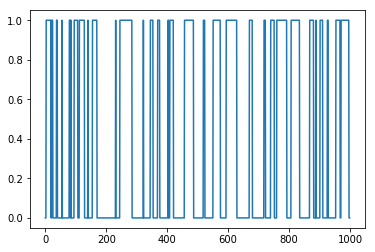

In [8]:
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
plt.plot(lab1000)

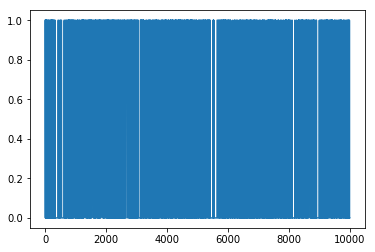

In [9]:
lab10000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
plt.plot(lab10000)

Посчитаем количество раз, когда использоволась какая кость для 10 000 раз

In [10]:
from collections import Counter
Counter(dataset10000Labels)

Counter({'F': 6332, 'U': 3668})

Все хорошо согласуется с предельным распределением, следовательно сплошная линия на графике для 10 000 ошибка изображения, но не моделирования

Определим базовый класс для алгоритмов, в котором будем хранить данные о нашей скрытой марковской цепи

In [11]:
class baseAlgo():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

## Алгоритм Витерби

Реализуем алгоритм Витерби

In [12]:
class algorithmViterbi(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability*np.max( self.v[index-1] * self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] * self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability*self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path

RESULT: 0.81
Probability: 4.43177686667641e-232


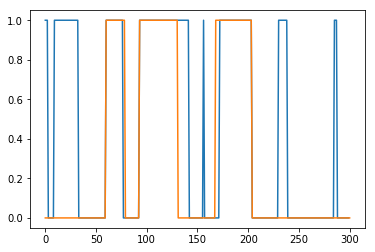

In [13]:
hackCasinoViterbi = algorithmViterbi(dataset300)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

RESULT: 0.656
Probability: 0.0


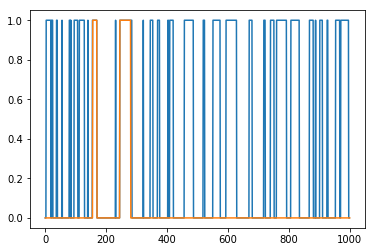

In [14]:
hackCasinoViterbi = algorithmViterbi(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

RESULT: 0.6336
Probability: 0.0


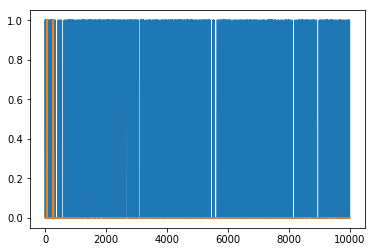

In [15]:
hackCasinoViterbi = algorithmViterbi(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

Из графиков икачетсва работы с 1000 и 10 000 экземпляров видно, что накапление машинной ошибки ведет к тому, что алгоритм уже не в состояние выдавать ненулевые значения. Чтобы избежать этого, перейдем в логарифмический масштаб

In [16]:
class baseAlgoLog():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.log([0.95,0.05]), # to F, to U
            'U': np.log([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': np.log(2/3),
            'U': np.log(1/3)
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': np.log([1/6 for i in range(6)]),
            'U': np.log([.1,.1,.1,.1,.1,.5])
        }

In [17]:
class algorithmViterbiLog(baseAlgoLog):
    def __init__(self, data):
        baseAlgoLog.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability + np.max( self.v[index-1] + self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] + self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability + self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = np.e**max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        

RESULT: 0.81
Probability: 4.431776866675352e-232


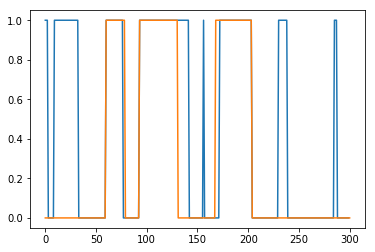

In [18]:
hackCasinoViterbiLog = algorithmViterbiLog(dataset300)
result = hackCasinoViterbiLog()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.777
Probability: 4.431776866675352e-232


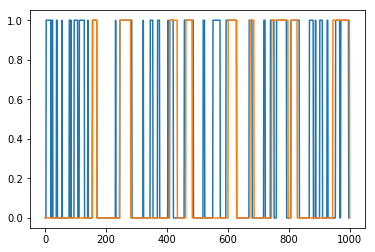

In [19]:
hackCasinoViterbi = algorithmViterbiLog(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.7846
Probability: 4.431776866675352e-232


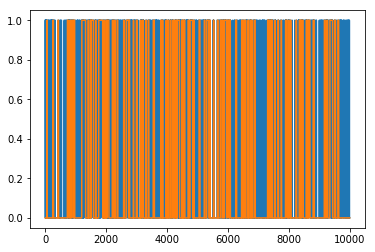

In [20]:
hackCasinoViterbi = algorithmViterbiLog(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab10000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

Использование логарифмического масштаба улучшило работы алгоритма, что видно как гарфически так и численно, в сравнение с правильными лейблами для костей.

## Алгорит прямого и обратного хода, апостериорное дешифрование

In [21]:
class forwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.f = []
        self.pathProbability = None
    
    def stepForward(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i,state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            
            """
            observedProbability: вероятсность наблюдения при текущем состояние
            transitionProbability: вероятность перехода с кубика на кубик
            """
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])

In [22]:
class backwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.b = []
        self.pathProbabilityB = None
    
    def stepBackward(self, index):
        self.b.append([])
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        nextState = self.b[-2]
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
    
    def __call__(self):
        if self.pathProbabilityB == None: self.initialization()
        return self.pathProbabilityB
    
    def initialization(self):
        self.b.append([1 for state in self.states])
        #Recursion
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        # Finish # перевернуть b
        self.b = self.b[::-1]
        self.pathProbabilityB = sum(self.b[0])

In [23]:
backwardHack = backwardAlgorithm(dataset300)
b=backwardHack()
forwardHack = forwardAlgorithm(dataset300)
f=forwardHack()

print('FORWARD: {}\nBACKWARD: {}\n'.format(f,b))

FORWARD: 1.3737344170048895e-222
BACKWARD: 9.853841759889607e-222



Проверим, что все считается верно: перемножим f и b в каждом столбце

In [24]:
pprint.pprint([sum(f*np.array(b)) for f, b in zip(forwardHack.f, backwardHack.b)])

[1.3737344170049076e-222,
 1.3737344170049075e-222,
 1.3737344170049075e-222,
 1.3737344170049075e-222,
 1.373734417004907e-222,
 1.3737344170049069e-222,
 1.3737344170049069e-222,
 1.3737344170049067e-222,
 1.3737344170049067e-222,
 1.3737344170049065e-222,
 1.3737344170049065e-222,
 1.3737344170049062e-222,
 1.3737344170049062e-222,
 1.3737344170049062e-222,
 1.3737344170049062e-222,
 1.3737344170049062e-222,
 1.373734417004906e-222,
 1.373734417004906e-222,
 1.373734417004906e-222,
 1.373734417004906e-222,
 1.373734417004906e-222,
 1.373734417004906e-222,
 1.3737344170049058e-222,
 1.3737344170049058e-222,
 1.3737344170049056e-222,
 1.3737344170049056e-222,
 1.3737344170049056e-222,
 1.3737344170049056e-222,
 1.3737344170049055e-222,
 1.3737344170049055e-222,
 1.3737344170049055e-222,
 1.3737344170049056e-222,
 1.3737344170049056e-222,
 1.3737344170049055e-222,
 1.3737344170049053e-222,
 1.3737344170049053e-222,
 1.3737344170049052e-222,
 1.373734417004905e-222,
 1.3737344170049047e

Так как на каждом шаге у нас выдается одна и таже величина, то прямой и обратный ход работfют корректно

In [60]:
class PosteriorDecoding(forwardAlgorithm, backwardAlgorithm):
    def __init__(self, data):
        #baseAlgo.__init__(self, data)
        forwardAlgorithm.__init__(self, data)
        backwardAlgorithm.__init__(self, data)
        # For decoding
        self.conditionalProbability = None
            
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        self.pathProbability = 0.0
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        
        self.b.append([1 for state in self.states])
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        for i in range(self.L):
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability
            self.conditionalProbability.append(conProb)

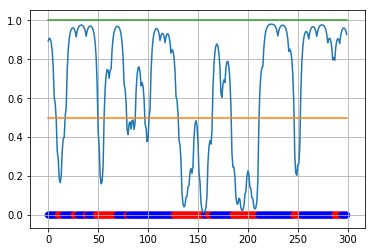

In [61]:
PosteriorHack = PosteriorDecoding(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


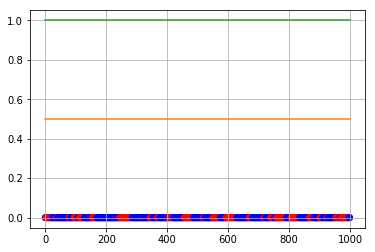

In [62]:
PosteriorHack = PosteriorDecoding(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


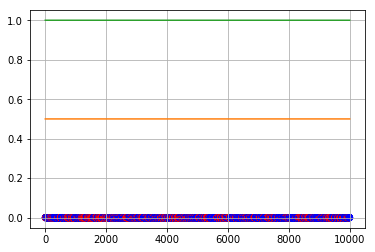

In [63]:
PosteriorHack = PosteriorDecoding(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

Из-за потери машиной точности, графики на последовательностях 1000 и 10 000 построить не получилось. Чтобы исправить эту проблему применим масштабирование для алгоритма декодирования

In [64]:
class PosteriorDecodingScaled(PosteriorDecoding):
    def __init__(self, data):
        PosteriorDecoding.__init__(self,data)
        # For scaling
        self.scaledConstF = []
        self.scaledConstB = []
        
    def stepForward(self, index):
        super().stepForward(index)
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
        
    def stepBackward(self, index):
        super().stepBackward(index)
        
        self.scaledConstB.append(max(self.b[-1]))
        self.b[-1] = self.b[-1]/self.scaledConstB[-1]        
        
    def initialization(self): # Тоже следует красиво переписать
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        
        self.b.append([1 for state in self.states])
        self.scaledConstB.append(1)
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        self.scaledConstB = self.scaledConstB[::-1]
        for i in range(self.L):
            # трюк чтобы не терять точность
            ###
            coeff = 1
            for backCoeff, forwardCoeff in zip(self.scaledConstB[i:],self.scaledConstF[i+1:]):
                coeff *= backCoeff/forwardCoeff
                
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability * coeff
            self.conditionalProbability.append(conProb)

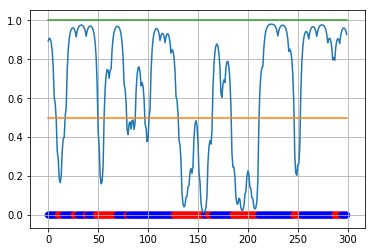

In [65]:
PosteriorHack = PosteriorDecodingScaled(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)

ax.plot([.5 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

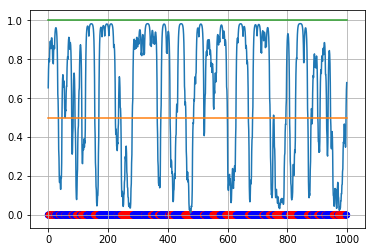

In [66]:
PosteriorHack = PosteriorDecodingScaled(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

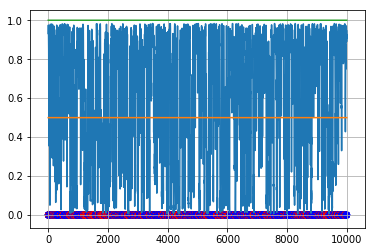

In [67]:
PosteriorHack = PosteriorDecodingScaled(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

## Алгоритм Баума-Велша

Реализуем класс с параметрами, которые не совпадают с параметрами используемой марковской цепи.

In [94]:
class parametrs:
    def __init__(self, data):
        
        self.isFitted = False
        
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.8,0.2]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [2/12,2/12,2/12,3/12,2/12,1/12],
            'U': [2/20,4/20,1/20,3/20,2/20,8/20]
        }

In [119]:
class BaumWelchTrainig(parametrs, PosteriorDecoding):
    def __init__(self, data):

        PosteriorDecoding.__init__(self, data)
        parametrs.__init__(self, data)
        
        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            self.f = []
            self.b = []
            self.pathProbability = .0
            self.initialization()
            # Change paramets
            self.changeParametrs()
            
            currentLog = self.logLikelihood()
            print("LOG: {}".format(currentLog))
            
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
        else:
            print('Stop: max iterations')
    
    def logLikelihood(self):
        return np.log(self.pathProbability)
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                sum_step = [
                    self.f[i][fromI] * self.b[i+1][newI] * 
                    self.diceValueProbability[newState][self.data[i+1] - 1] 
                    for i in range(self.L-1)
                ]
                probability = sum(sum_step) * self.transitionsProbability[fromState][newI]#/self.pathProbability
                A[fromState][newState] = probability
        # Add B
        B = {}
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for i,value in enumerate(self.data):
                B[state][value - 1] =+ self.f[i][index] * self.b[i][index]
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
        
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

In [120]:
trainig = BaumWelchTrainig(dataset300)
trainig()

STARTED:  -532.7423534019077
LOG: -532.7423534019077
LOG: -533.4374196542872
LOG: -545.6534606511858
LOG: -551.1474405819478
LOG: -544.7201866535597
LOG: -540.0387666177742
LOG: -538.5277459833834
LOG: -538.0441763494813
LOG: -537.8698858836893
LOG: -537.7969580238664
LOG: -537.7629375945849
LOG: -537.7455073893628
LOG: -537.7355986068726
LOG: -537.7291799721127
LOG: -537.7243477963467
LOG: -537.7201679104975
LOG: -537.7161722753801
LOG: -537.7121250470786
LOG: -537.7079082643606
LOG: -537.7034638881
LOG: -537.6987636495068
LOG: -537.693793126593
LOG: -537.6885433063875
LOG: -537.6830061719763
LOG: -537.67717249381
LOG: -537.6710308533368
LOG: -537.664567379071
LOG: -537.6577659220322
LOG: -537.6506085347412
LOG: -537.6430761944345
LOG: -537.6351497518477
LOG: -537.6268111041069
LOG: -537.6180445894606
LOG: -537.6088385846706
LOG: -537.5991872534889
LOG: -537.5890923480848
LOG: -537.5785649084844
LOG: -537.5676266462348
LOG: -537.5563107506481
LOG: -537.5446618357453
LOG: -537.53273476

После тренировке на 300 бросках, алгоритм смог равномерно раскидать выпадающие значения на кубиках, а так же смог уловить общую тенденцию в переходах между кубиками (проще остаться с этим же кубиком, чем перейти), и в общих чертах смог выделить нечестный кубик.

In [79]:
trainig = BaumWelchTrainig(dataset1000)
trainig()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


LOG: -inf
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
Stop: max iterations
'FITTED'
'Parametrs'
"TransitionsProbability: {'F': array([nan, nan]), 'U': ar

На 1000 бросках происходит накопление ошибки, что ведет к переполнению переменных.
Сделаем нормированную версию алгоритма

In [37]:
def multiply(array):
    result = 1
    for i in array:
        result *= i
    return result

In [80]:
class BaumWelchTrainigScaled(parametrs, PosteriorDecodingScaled):
    def __init__(self, data):

        PosteriorDecoding.__init__(self, data)
        parametrs.__init__(self, data)

        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            self.scaledConstF = []
            self.scaledConstB = []
            
            self.f = []
            self.b = []
            
            self.initialization()
            
            # Change paramets
            self.changeParametrs()
            currentLog = self.logLikelihood()
            print(currentLog)
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
        else:
            print('Stop: max iterations')
    
    
    def logLikelihood(self):
        return np.log(self.pathProbability*multiply(self.scaledConstF))

    def coeff(self,currentI):
        # трюк чтобы не терять точность
        ###
        coeff_num = 1
        for backCoeff, forwardCoeff in zip(self.scaledConstB[currentI+1:],self.scaledConstF[currentI:]):
            coeff_num *= backCoeff/forwardCoeff
        return coeff_num
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                sum_step = [
                    self.f[i][fromI] * self.b[i+1][newI] * 
                    self.diceValueProbability[newState][self.data[i+1] - 1] * self.coeff(i)
                    for i in range(self.L-1)
                ]
                probability = sum(sum_step) * self.transitionsProbability[fromState][newI]/self.pathProbability
                A[fromState][newState] = probability
        # Add B
        
        
        B = {}
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for i,value in enumerate(self.data):
                B[state][value - 1] =+ self.f[i][index] * self.b[i][index] * multiply(self.scaledConstF[:i + 1]) * multiply(self.scaledConstB[i:])
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
        
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

In [81]:
trainig = BaumWelchTrainigScaled(dataset300)
trainig()

-532.9450661217631
-533.6266805087831
-546.0402244768436
-552.1918055354993
-545.8525248245253
-540.7311855036653
-538.8802708539672
-538.265819022587
-538.0518178867482
-537.9509016660224
-537.8915147746252
Log doesnot change: stop in 10 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([0.97306724, 0.02693276]), 'U': "
 'array([0.85226325, 0.14773675])}')
("diceValueProbability: {'F': [0.16176110440590294, 0.17081080239353028, "
 '0.17178598331347403, 0.15623785584437808, 0.16973688633727252, '
 "0.16966736770544216], 'U': [0.32496429608719635, 0.03293951640574951, "
 '0.0014713951838609433, 0.5031940498878605, 0.06759372256310459, '
 '0.06983701987222833]}')


In [82]:
trainig = BaumWelchTrainigScaled(dataset1000)
trainig()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Stop: max iterations
'FITTED'
'Parametrs'
"TransitionsProbability: {'F': array([nan, nan]), 'U': array([nan, nan])}"
("diceValueProbability: {'F': [nan, nan, nan, nan, nan, nan], 'U': [nan, nan, "
 'nan, nan, nan, nan]}')


Нормировка не очень помогла -  на каком-то шаге все равно произошло переполнение.  
Попробуем разбить 10 000 состояний на некоторе количество состояний по 300

In [42]:
dataset300_10 = []

casino = Croupier()
for j in range(10):
    dataset300_10.append([])
    for i in range(300):
        data, _ = casino()
        dataset300_10[j].append(data)

In [43]:
class parametrsMany(parametrs):
    def __init__(self, data):
        parametrs.__init__(self, data)
        self.number = len(data)
        self.L = len(data[0])

In [44]:
class specialForward(parametrsMany):
    def __init__(self, data):
        parametrsMany.__init__(self, data)
        
    
    def stepForward(self, J, index):
        self.f[J].append([])
        previuosState = self.f[J][-2]
        for i,state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[J][index] - 1]
            #print(observedProbability)
            #print(previuosState)
            #print(J, " : ",index," : ", transitionProbability)
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[J][-1].append(probability)
            
    def initializationForward(self):
        self.f = [[] for i in range(self.number)]
        self.pathProbability = []
        for J in range(self.number):
            self.f[J].append([self.startProbability[state] for state in self.states] * 
                          np.array([self.diceValueProbability[state][self.data[J][0] - 1] for state in self.states]))
            for i in range(1,self.L):
                self.stepForward(J,i)
            self.pathProbability.append(sum(self.f[J][-1]))

In [45]:
class specialBackward(parametrsMany):
    def __init__(self, data):
        parametrsMany.__init__(self, data)
    
    def stepBackward(self, J, index):
        self.b[J].append([])
        observedProbability =  np.array([val[self.data[J][index]-1] for val in self.diceValueProbability.values()])
        nextState = self.b[J][-2]
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[J][-1].append(probability)
    
    def initializationBackward(self):
        self.b = [[] for i in range(self.number)]
        for J in range(self.number):
            self.b[J].append([1 for state in self.states])
            #Recursion
            for i in range(self.L-1,0,-1):
                self.stepBackward(J,i)

            # Finish # перевернуть b
            self.b[J] = self.b[J][::-1]

In [56]:
class BaumWelchTrainigMany(specialForward, specialBackward):
    def __init__(self, data):
        
        specialForward.__init__(self, data)
        specialBackward.__init__(self, data)
        
        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            
            self.initializationForward()
            self.initializationBackward()
            
            # Change paramets
            self.changeParametrs()
            currentLog = self.logLikelihood()
            print(currentLog)
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
        else:
            print('Stop: max iterations')
    
    
    def logLikelihood(self):
        return sum(np.log(self.pathProbability))
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                A[fromState][newState] = 0.0
                for J in range(self.number):
                    sum_step = [
                        self.f[J][i][fromI] * self.b[J][i+1][newI] * 
                        self.diceValueProbability[newState][self.data[J][i+1] - 1] 
                        for i in range(self.L-1)
                    ]
                    probability = sum(sum_step) * self.transitionsProbability[fromState][newI]/self.pathProbability[J]
                    A[fromState][newState] += probability
                A[fromState][newState] /= self.number
        # Add B
        B = {}
        
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for J in range(self.number):
                for i,value in enumerate(self.data[J]):
                    B[state][value - 1] =+ self.f[J][i][index] * self.b[J][i][index] / self.number
        
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
        # Выводить вероятность последовательности
        
        
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

In [57]:
trainig = BaumWelchTrainigMany(dataset300_10)
trainig()

-5335.098300366397
-5361.395869156871
-5387.424421993425
-5407.41301778244
-5414.149863009688
-5411.096617723873
-5392.368327307794
-5372.891243626569
-5362.237076506715
-5358.7631469530015
-5358.295868908843
-5358.700659179201
-5359.306939528141
-5359.951946461733
-5360.605404978839
-5361.265408762516
-5361.934453972189
-5362.615307555591
-5363.310882297117
-5364.024341090325
-5364.758717773207
-5365.51613381121
-5366.296901443275
-5367.098821416528
-5367.91689130489
-5368.743487002199
-5369.568932132965
-5370.382289787542
-5371.172216577747
-5371.927776579231
-5372.6391673877515
-5373.298329381985
-5373.899399331257
-5374.438960767666
-5374.91605901586
-5375.331987659583
-5375.689896655466
-5375.994300227266
-5376.250566365337
-5376.464453253966
-5376.641731872209
-5376.787908564078
-5376.908042595483
-5377.006643239444
Log doesnot change: stop in 43 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([0.00654727, 0.99345273]), 'U': "
 'array([0.00427277, 0.99572723]

Результаты занятны: в этом случае алгоритм счтает что вероятность перехода на первый кубик составляет 10 процентов, и первый кубик используется только для генерации одного числа - в этом случае 3.